In [80]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
%matplotlib inline

seed = 99
np.random.seed(seed)
tf.random.set_seed(seed)

**Description of the Pneumonia Dataset**

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

In [2]:
input_path = 'chest_xray/'
order = ['train', 'val', 'test']

In [3]:
# https://www.kaggle.com/code/sainiamit/chest-xray-pneumonia-image-classification
labels = ['normal','pneumonia']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_training_data(input_path + 'train')
test = get_training_data(input_path + 'test')
val = get_training_data(input_path + 'val')

OpenCV(4.6.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/var/folders/x6/vpw6gfrj0dqg14k3cvcvlfqh0000gn/T/ipykernel_7427/3724749324.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.6.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



## Q1: Exploratory Data Analysis (4 Pts)

Download and explore the data. Explore label distribution and qualitatively describe the data by plotting healthy and pneumonia samples. Do you see visual differences between healthy and disease samples? Do you find sources of bias that could influence model performance? How do you preprocess the data for your further analysis?

**Label distribution**

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 229, pneumonia images: 385


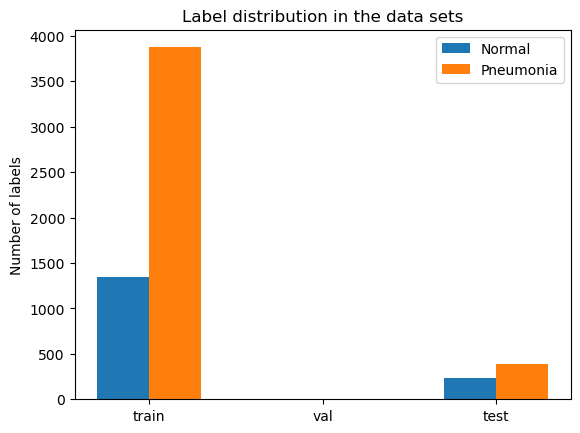

In [5]:
Normal = []
Pneumonia = []
for _set in order:
    li = os.listdir(input_path + _set + '/NORMAL')
    if ('.DS_Store' in li): li.remove('.DS_Store')
    n_normal = len(li)
    Normal.append(n_normal)
    
    la = os.listdir(input_path + _set + '/PNEUMONIA')
    if ('.DS_Store' in la): la.remove('.DS_Store')
    n_infect = len(la)
    Pneumonia.append(n_infect)
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

x = np.arange(len(order))
width = 0.30  
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Normal, width, label='Normal')
rects2 = ax.bar(x + width/2, Pneumonia, width, label='Pneumonia')

ax.set_ylabel('Number of labels')
ax.set_xticks(x)
ax.set_xticklabels(order)
ax.legend()
plt.title("Label distribution in the data sets")
plt.show()

In [6]:
label_dist = pd.DataFrame({'Normal': Normal, 'Pneumonia': Pneumonia}
                         , index=['Train','Val','Test'])
label_dist

Normal  Pneumonia
Train    1341       3875
Val         8          8
Test      229        385

Text(0.5, 1.0, 'Test data')

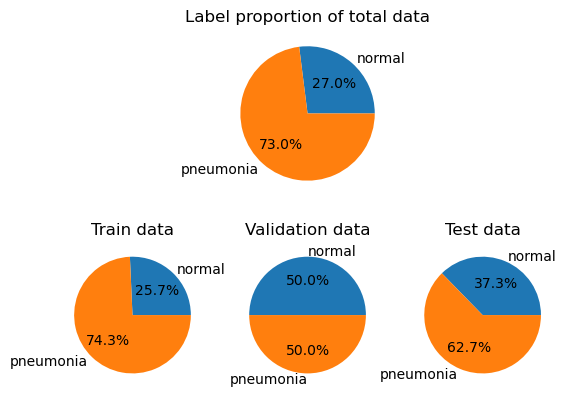

In [7]:
fig, axes = plt.subplot_mosaic("AAA;BCD")
axes["A"].pie((sum(label_dist['Normal']),sum(label_dist['Pneumonia'])),
        labels=labels,
        autopct='%1.1f%%')
axes["A"].set_title('Label proportion of total data')
axes["B"].pie((label_dist.iloc[0,0],label_dist.iloc[0,1]),
        labels=labels,
        autopct='%1.1f%%')
axes["B"].set_title('Train data')
axes["C"].pie((label_dist.iloc[1,0],label_dist.iloc[1,1]),
        labels=labels,
        autopct='%1.1f%%')
axes["C"].set_title('Validation data')
axes["D"].pie((label_dist.iloc[2,0],label_dist.iloc[2,1]),
        labels=labels,
        autopct='%1.1f%%')
axes["D"].set_title('Test data')


**Healthy vs. pneumonia samples**

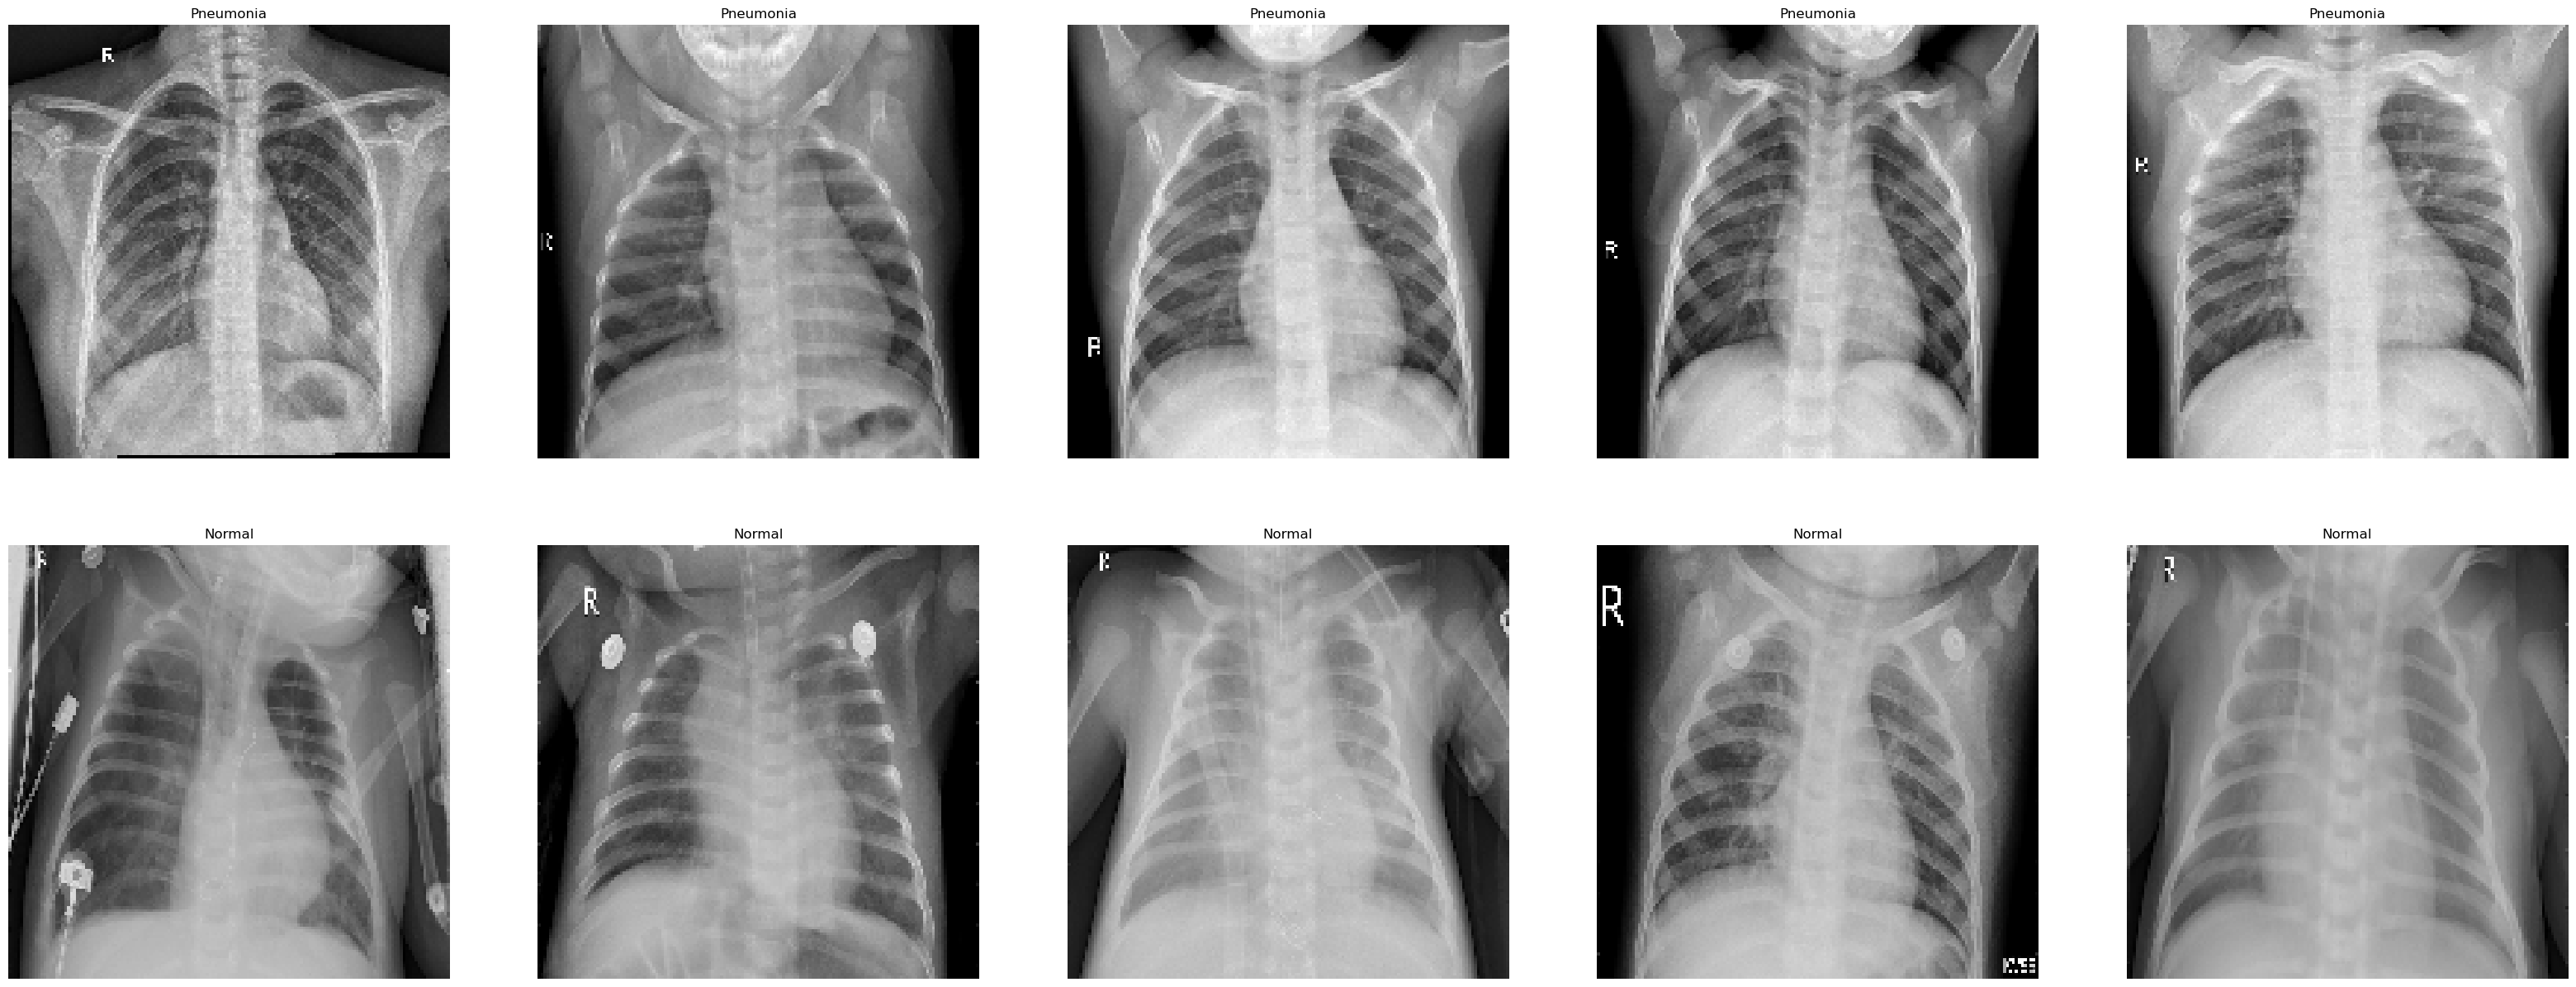

In [8]:
f, ax = plt.subplots(2,5, figsize=(40,15))
j = 0
i = 0
while j < 5:
    if train[i][1] == 0: # Label Pneumonia: 0
        ax[j//5, j%5].imshow(train[i][0], cmap='gray')
        ax[j//5, j%5].set_title("Pneumonia")
        ax[j//5, j%5].axis('off')
        ax[j//5, j%5].set_aspect('auto')
        j+=1
    i+=1
while j < 10:
    if train[i][1] == 1: # Label Normal: 1
        ax[j//5, j%5].imshow(train[i][0], cmap='gray')
        ax[j//5, j%5].set_title("Normal")
        ax[j//5, j%5].axis('off')
        ax[j//5, j%5].set_aspect('auto')
        j+=1
    i+=1

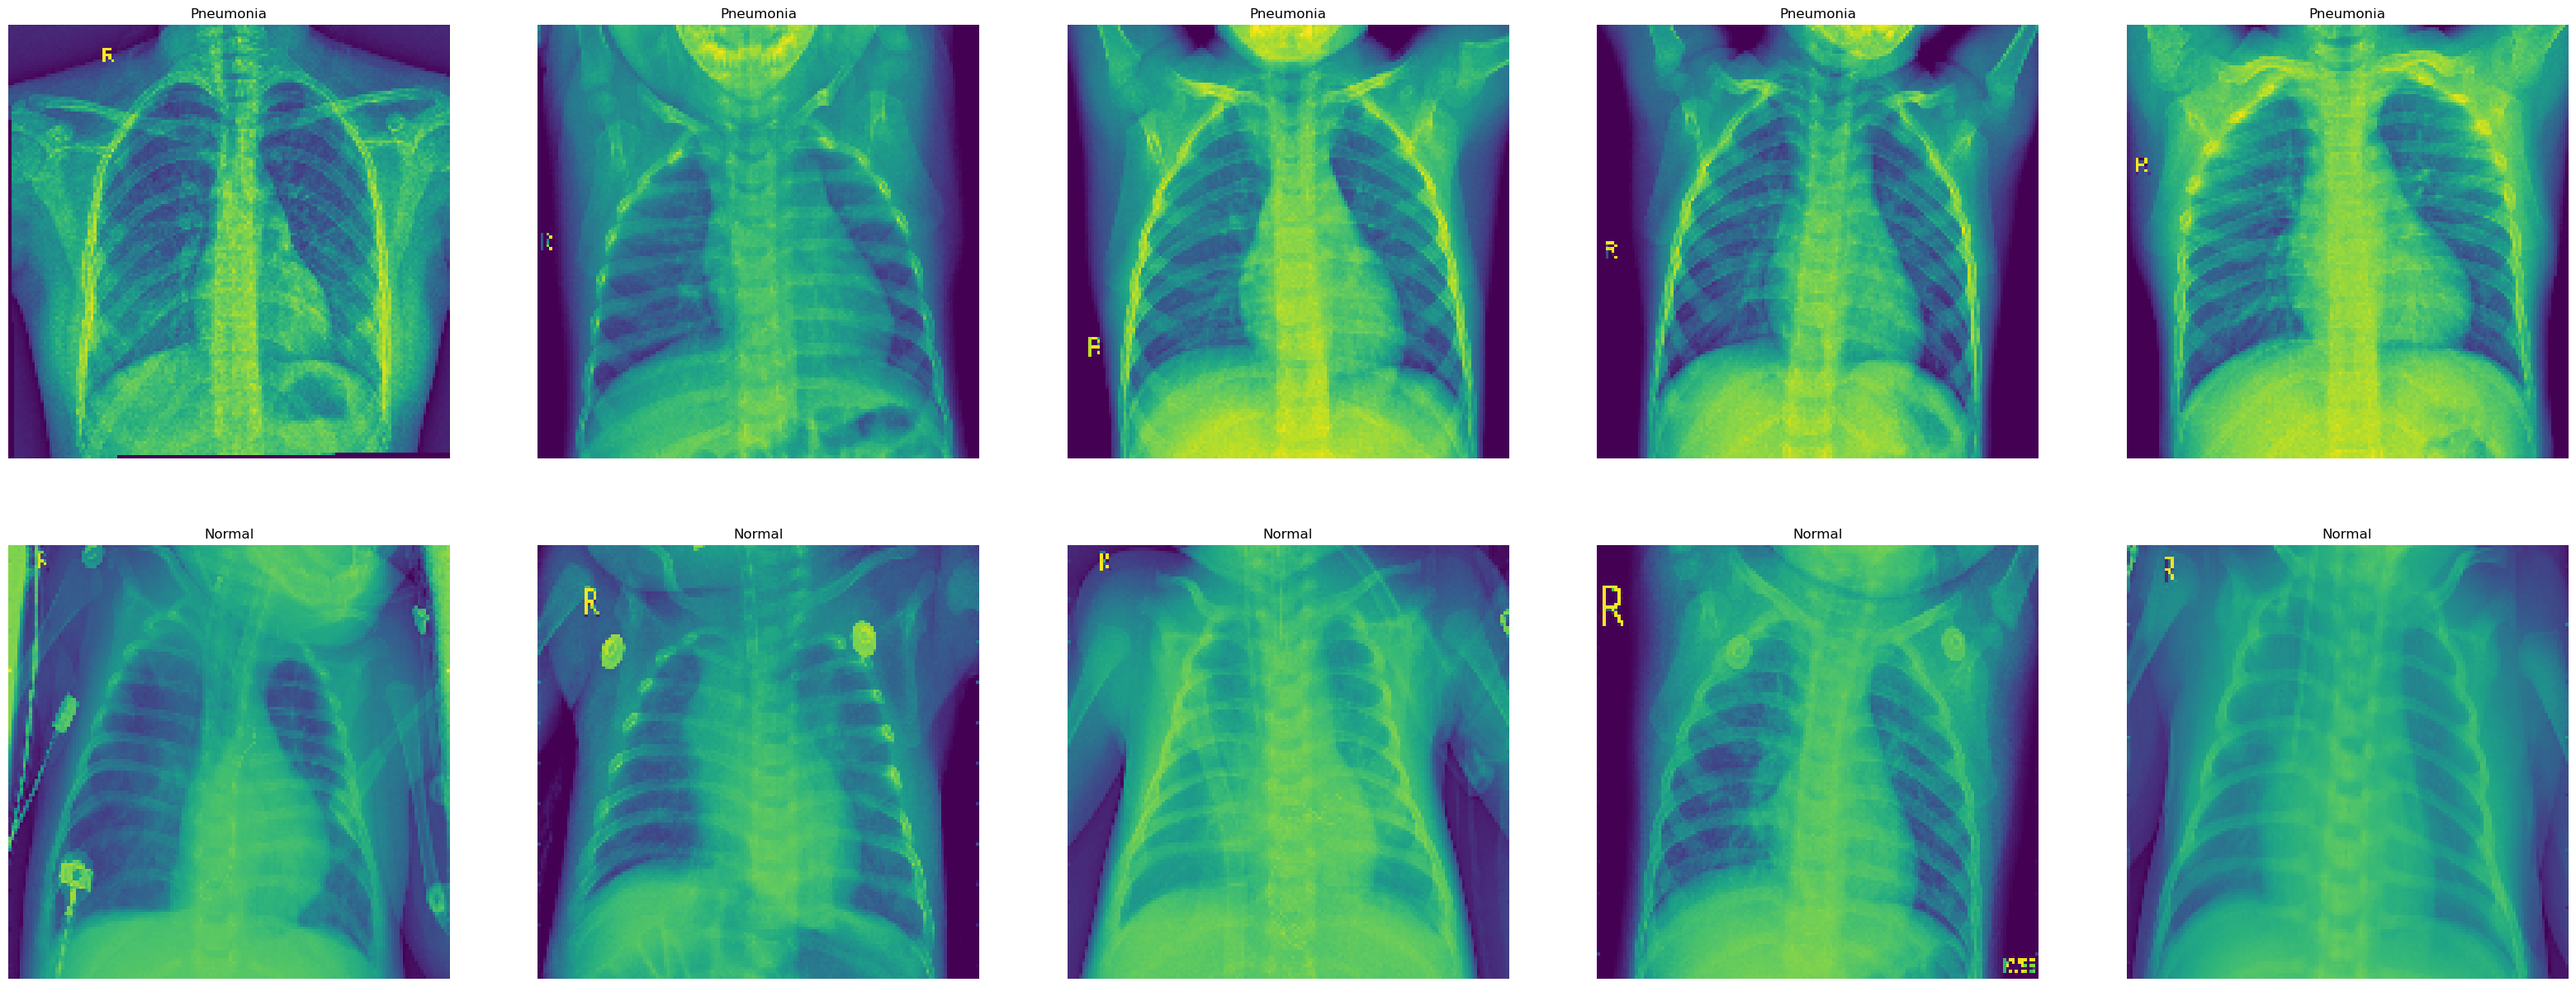

In [9]:
f, ax = plt.subplots(2,5, figsize=(40,15))
j = 0
i = 0
while j < 5:
    if train[i][1] == 0: # Label Pneumonia: 0
        ax[j//5, j%5].imshow(train[i][0])
        ax[j//5, j%5].set_title("Pneumonia")
        ax[j//5, j%5].axis('off')
        ax[j//5, j%5].set_aspect('auto')
        j+=1
    i+=1
while j < 10:
    if train[i][1] == 1: # Label Normal: 1
        ax[j//5, j%5].imshow(train[i][0])
        ax[j//5, j%5].set_title("Normal")
        ax[j//5, j%5].axis('off')
        ax[j//5, j%5].set_aspect('auto')
        j+=1
    i+=1


 *Do you see visual differences between healthy and disease samples?* 
- Some Pneumoinia cases have white "clounds" in the pictures. The pictures look more "noisy" in the area of the lungs.
- Surgeons apparently see white points and white shaddows 

*Do you find sources of bias that could influence model performance?*
- The labels are not distributed to equal parts. There are more pneumonia cases in the test and training set.
- The validation set is very small, only 0.3% of the training data set
- ...

In [10]:
8*2/sum((label_dist.iloc[0,0],label_dist.iloc[0,1]))*100

0.3067484662576687

To achive more stable results we combine the pre-defined train and validation data and set a new random split. This is done in the next preprocessing step (https://www.kaggle.com/code/sainiamit/chest-xray-pneumonia-image-classification). 

**Additional preprocessing**

A) Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are:
- grayscales
- horizontal flips (very effective)
- vertical flips
- random crops
- color jitters
- translations
- rotations
- and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

Shuffling is applied to the training data to break possible biases during data preparation.

In [11]:
img_size = 224 
batch_size= 32 # default
color = 'rgb'

train_datagen = ImageDataGenerator(rescale=1/255., # normalize
                #rotation_range = 30, #0  # randomly rotate images in the range (degrees, 0 to 180)
                zoom_range = 0.2, #0.0 # Randomly zoom image 
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip = True,  # Randomly flip inputs horizontally
                #validation_split=0.1, # Used to create the random split
                fill_mode = 'constant'                  
                                  )
                                   
val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.) # normalize


train_generator = train_datagen.flow_from_directory('chest_xray/train', # note that we now use the folder that contains both train and validation data
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    color_mode='rgb', # default
                                                    shuffle = True,
                                                    class_mode ='binary',
                                                    seed = 99)

val_generator = val_datagen.flow_from_directory('chest_xray/val',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False,
                                                class_mode ='binary',
                                                seed = 99)

test_generator = test_datagen.flow_from_directory('chest_xray/test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False, 
                                                class_mode ='binary',
                                                seed = 99)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 614 images belonging to 2 classes.


The following shows some results after data augmentation

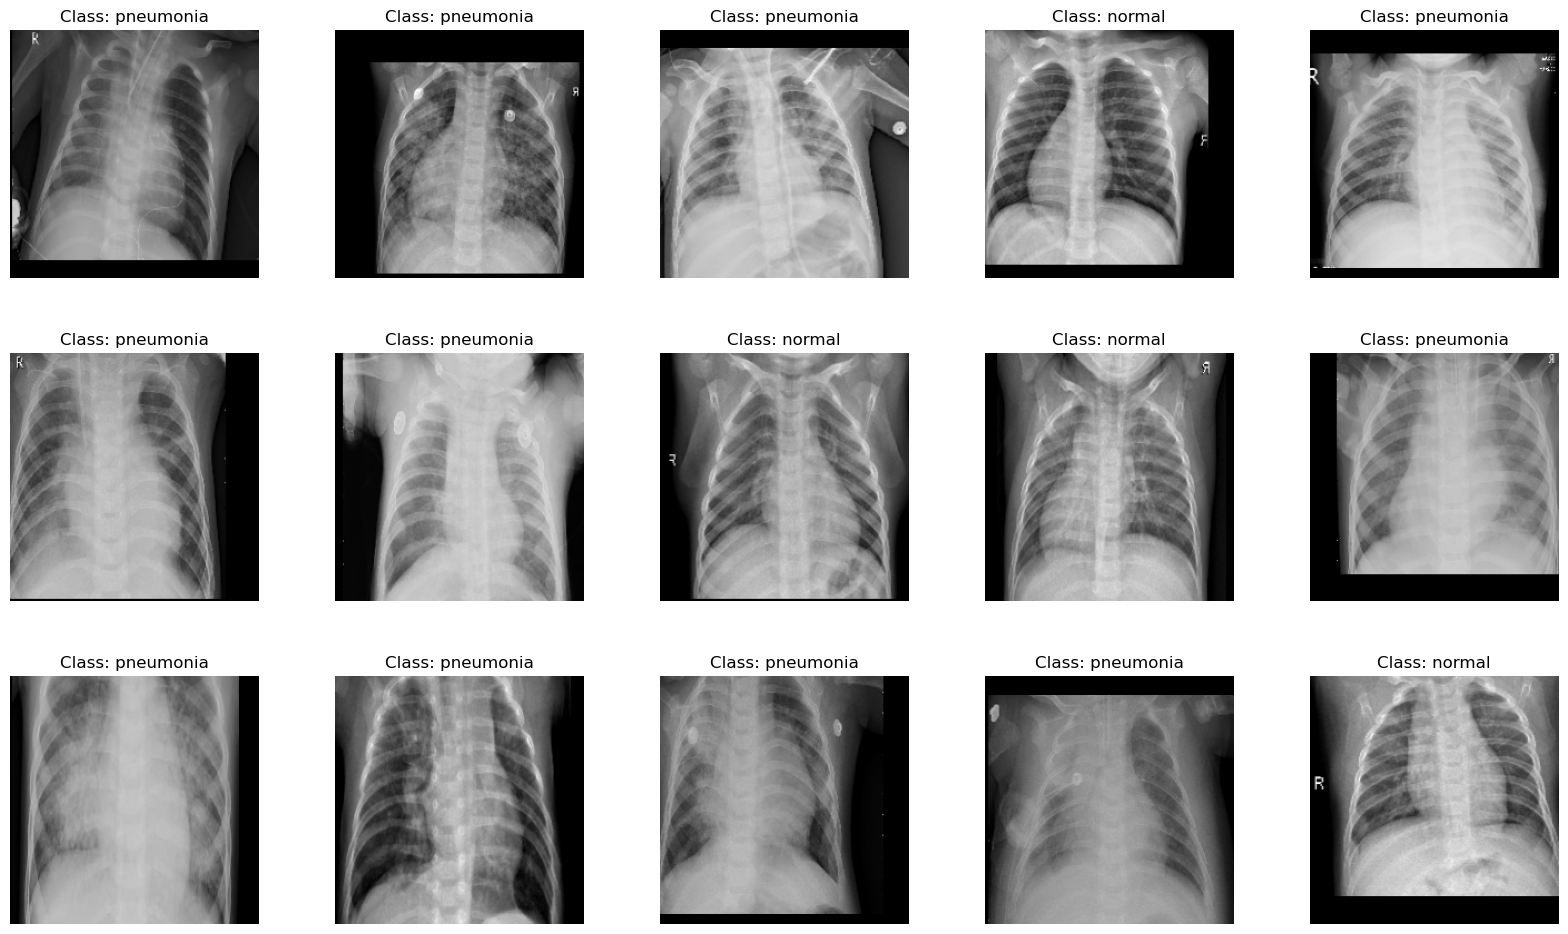

In [12]:
# https://www.kaggle.com/code/srishtik05/normal-vs-pneumonia-cnn
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

**Q2: CNN Classifier (4 Pts)**

In Q3 and Q4, we aim to use post-hoc explainability methods for visualizing the parts of the image that are important for the prediction of a model. Thus, design a small CNN classifier for the dataset and report its performance on a test set. Make sure to elaborate on your architecture and training details.

Dense layer is used to regularize.

Data augmentation “increased” the data set to reduce the generalization gap (generalization gap: the gap between model performance in the training set and model performance test set).
https://jinwen17.medium.com/tricks-to-prevent-overfitting-in-cnn-model-trained-on-a-small-dataset-b84f05eb4eb7

*Why using recall?*

The problem are false negatives. Thus, a person has pneumonia but the detector says its results are normal. The recall uses the correctly labeled samples w.r.t. all pneumonia samples. It thus includes the relationship to the false negative samples. Thats why recall is an appropriate metric for this case.

In [13]:
channel = 3
cnnt = Sequential()

cnnt.add(Conv2D(16,3, input_shape=(img_size,img_size,channel), activation='relu', padding='same'))
cnnt.add(MaxPooling2D((2,2) , padding = 'same'))

cnnt.add(Conv2D(32,3, activation='relu', padding='same'))
cnnt.add(Dropout(0.1))
cnnt.add(MaxPooling2D((2,2) , padding = 'same'))

cnnt.add(Conv2D(64,3, activation='relu', padding='same'))
cnnt.add(MaxPooling2D((2,2) , padding = 'same'))
cnnt.add(Dropout(0.2))

cnnt.add(Conv2D(64,3, activation='relu', padding='same'))
cnnt.add(MaxPooling2D((2,2) , padding = 'same'))

cnnt.add(Flatten())

cnnt.add(Dense(256, activation ='relu'))
cnnt.add(Dense(1, activation = 'sigmoid'))


In [14]:
cnnt.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [15]:
#plot_model(cnn, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
cnnt.compile(optimizer= 'nadam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

checkpoint = ModelCheckpoint("model_1",
                             monitor='val_accuracy',
                             mode='max', # since we minimize val_loss
                             verbose=1,
                             # save_freq='epoch', #default: 'epoch'
                             save_best_only=True, #default: F
                             # save_weights_only=False #default: F
                            )

historyt = cnnt.fit(train_generator, 
                  validation_data= val_generator,
                  epochs = 12 # 200
                  , callbacks= [checkpoint]
                 )

In [25]:
#cnnt.save("model_lowV_91.h5")

In [27]:
#c2 = load_model("model_lowV_91.h5")

In [17]:
c3 = load_model("model_1")

### Evaluation

In [18]:
def loss_acc_plot(model):
    model_df = pd.DataFrame(model.history)
    plt.figure(figsize=(20,8))
    plt.plot(model_df['loss'])
    plt.plot(model_df['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    plt.figure(figsize=(20,8))
    plt.plot(model_df['accuracy'])
    plt.plot(model_df['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [19]:
def pred_eval(model, typ):
    if typ == 'validation':
        generator = val_generator
    elif typ == 'test':
        generator = test_generator
    else: 
        print("Wrong analysis type: choose validation or test")
        return 
    
    classes = generator.classes
    y_val = model.predict(generator)
    y_val[y_val>0.5] = 1
    y_val[y_val<0.5] = 0
    
    print(classification_report(classes,y_val,target_names=labels))
    
    acc_v1 = accuracy_score(classes,y_val)
    print(typ+' accuracy of model is',acc_v1*100)

    recall_test_v1 = recall_score(classes,y_val)
    print(typ+' recall of model is',recall_test_v1*100)

    prec_v1 = precision_score(classes,y_val)
    print(typ+' precision of model is',prec_v1*100)

    f1_v1 = f1_score(classes,y_val)
    print(typ+' f1 Score of model is', f1_v1*100)

    sns.heatmap(confusion_matrix(classes,y_val),annot=True,fmt='.3g'
        ,xticklabels=['NORMAL','PNEUMONIA']
        ,yticklabels=['NORMAL','PNEUMONIA']
        ,cmap='Blues')
    plt.show()

**Overfitting**

In [17]:
#loss_acc_plot(historyt)

**Evalution on validation data**

1/1 [==============================] - 0s 174ms/step
              precision    recall  f1-score   support

      normal       0.86      0.75      0.80         8
   pneumonia       0.78      0.88      0.82         8

    accuracy                           0.81        16
   macro avg       0.82      0.81      0.81        16
weighted avg       0.82      0.81      0.81        16

validation accuracy of model is 81.25
validation recall of model is 87.5
validation precision of model is 77.77777777777779
validation f1 Score of model is 82.3529411764706


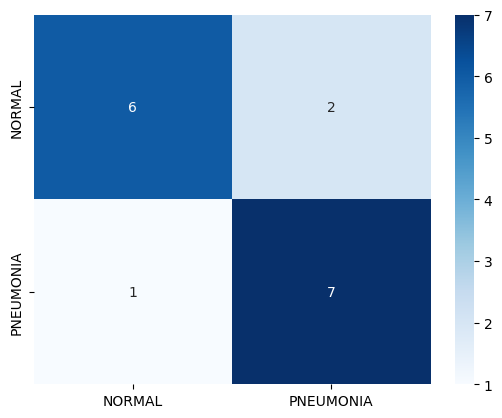

In [20]:
pred_eval(c3, 'validation')

**Evalution on test data**

20/20 [==============================] - 3s 140ms/step
              precision    recall  f1-score   support

      normal       0.92      0.87      0.89       229
   pneumonia       0.92      0.95      0.94       385

    accuracy                           0.92       614
   macro avg       0.92      0.91      0.92       614
weighted avg       0.92      0.92      0.92       614

test accuracy of model is 92.18241042345277
test recall of model is 95.32467532467533
test precision of model is 92.44332493702771
test f1 Score of model is 93.8618925831202


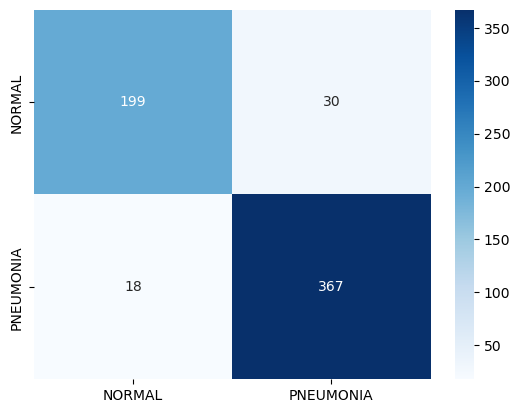

In [21]:
pred_eval(c3, 'test')

In [22]:
tester = c3.evaluate(test_generator)
print("Loss of the model is - " , c3.evaluate(test_generator)[0])
print("Accuracy of the model is - " , c3.evaluate(test_generator)[1]*100 , "%")

20/20 [==============================] - 3s 149ms/step - loss: 0.3278 - accuracy: 0.9218 - recall_2: 0.9532
Loss of the model is -  0.32782214879989624
20/20 [==============================] - 3s 149ms/step - loss: 0.3278 - accuracy: 0.9218 - recall_2: 0.9532
Accuracy of the model is -  92.18240976333618 %


20/20 [==============================] - 3s 150ms/step


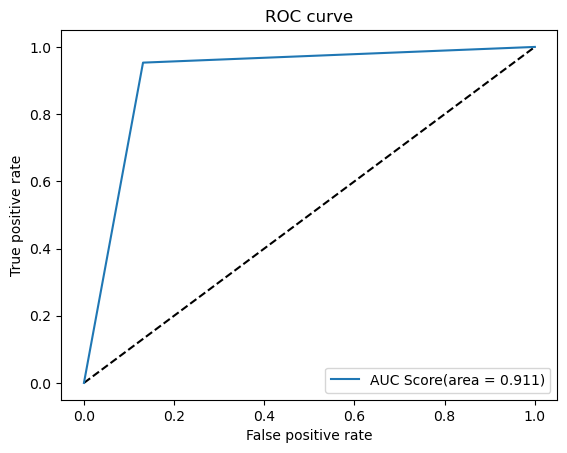

In [23]:
# y_preds = preds.ravel()
classes = test_generator.classes
y_preds = c3.predict(test_generator)
y_preds[y_preds>0.5] = 1
y_preds[y_preds<0.5] = 0
model_fpr, model_tpr, model_threshold = roc_curve(classes, y_preds)
model_auc = auc(model_fpr, model_tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(model_fpr, model_tpr, label='AUC Score(area = {:.3f})'.format(model_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Q3: Integrated Gradients (4 Pts)

Like MLPs, CNNs perform very well in tasks like classification but lack interpretability due to their black-box nature. Again, post-hoc explainability methods are thus suitable alternatives. One class of post-hoc procedures specific to image data are methods generating attribution maps, which try to highlight the most important regions on which the CNN bases its predictions. 

For this part of the assignment, implement the integrated gradient method. Visualize attribution maps of five healthy and five disease test samples. Do the maps highlight sensible regions? Are attributions consistent across samples? Do they match potential observations from Q1?

Original paper: https://arxiv.org/pdf/1703.01365.pdf <br>
Tensorflow reference: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
https://www.kaggle.com/code/dschettler8845/hpa-xai-ig-eda

We will use a black image as baseline thus the pixel values are all zero.

In [24]:
chanels = 3

In [25]:
baseline = tf.zeros(shape=(img_size,img_size,chanels))

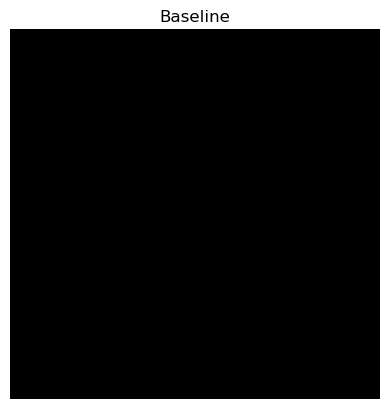

In [26]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

We also select 5 pneumonia and 5 normal images (that are used as input in the nns - thus augmented)

In [27]:
test_generator_n = test_datagen.flow_from_directory('Samples',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False, 
                                                class_mode ='binary',
                                                seed = 99)

Found 10 images belonging to 2 classes.


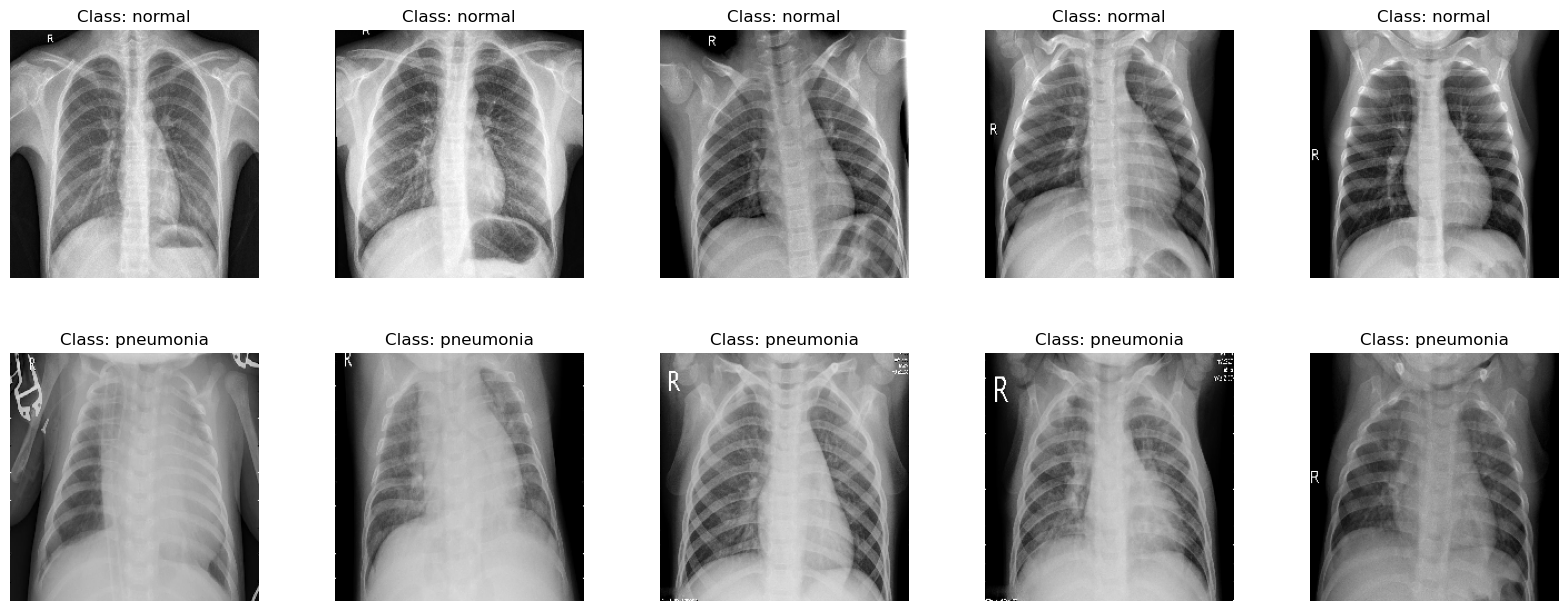

In [28]:
samples_s = test_generator_n.__next__()
imagess = samples_s[0]
targets = samples_s[1]
pnom = []
norm = []
plt.figure(figsize = (20 , 20))
for i in range(10):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(imagess[i])
    plt.title(f"Class: {labels[int(targets[i])]}")
    plt.axis('off')
    if targets[i] == 1:
        pnom.append(imagess[i])
    else:
        norm.append(imagess[i])

Now we start with the gradient calculation

In [29]:
m_steps = 25
alphas = tf.linspace(start=0.0, stop=1.0, num = m_steps+1)

In [30]:
def interpolate_images(baseline, image, alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [31]:
ii_p = []
ii_n = []
for i in pnom:
    ii_p.append(interpolate_images(baseline=baseline,image=i,alphas=alphas))
for i in norm:
    ii_n.append(interpolate_images(baseline=baseline,image=i,alphas=alphas))


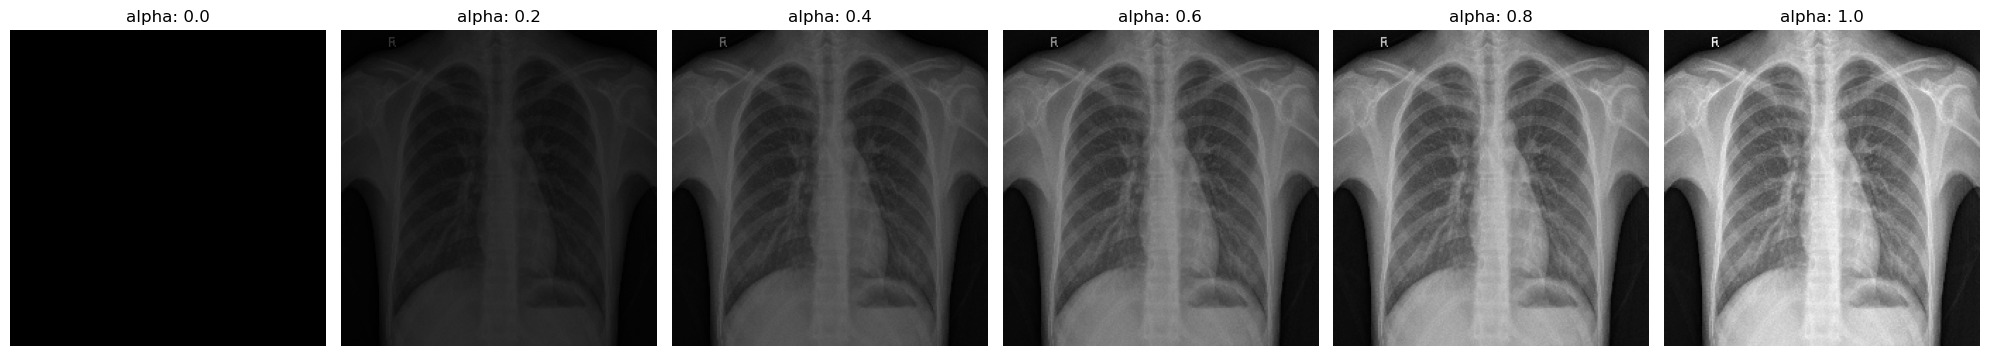

In [32]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::5], ii_n[0][0::5]):
  i += 1
  plt.subplot(1, len(alphas[0::5]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [33]:
def compute_gradients(images, target_class_idx):
    if images.dtype != tf.float32:
        images = tf.cast(images, tf.float32)
    
    if tf.math.reduce_max(images)<=1.:
        images *= 255.

    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = c3(images)[:, target_class_idx]
        res = tape.gradient(logits, images)
        
    return res

In [34]:
c3(ii_p[0])

<tf.Tensor: shape=(26, 1), dtype=float32, numpy=
array([[0.99219155],
       [0.99300563],
       [0.993213  ],
       [0.9924779 ],
       [0.99171454],
       [0.9928483 ],
       [0.9948581 ],
       [0.99680895],
       [0.99828595],
       [0.9993526 ],
       [0.9997392 ],
       [0.9998656 ],
       [0.99992186],
       [0.99994135],
       [0.9999531 ],
       [0.99997276],
       [0.99998814],
       [0.9999934 ],
       [0.99999386],
       [0.99999315],
       [0.99998873],
       [0.99997634],
       [0.99995786],
       [0.9999499 ],
       [0.99994874],
       [0.999951  ]], dtype=float32)>

In [35]:
coga_p = []

In [36]:
images = ii_p[0]
with tf.GradientTape() as tape:
        tape.watch(images)
        logits = c3(images)[:,:]
        res = tape.gradient(logits, images)
        coga_p.append(res)

In [37]:
images = ii_p[1]
with tf.GradientTape() as tape:
        tape.watch(images)
        logits = c3(images)[:,:]
        res = tape.gradient(logits, images)
        coga_p.append(res)

In [60]:
images = ii_p[2]
with tf.GradientTape() as tape:
        tape.watch(images)
        logits = c3(images)[:,:]
        res = tape.gradient(logits, images)
        coga_p.append(res)

In [63]:
images = ii_p[3]
with tf.GradientTape() as tape:
        tape.watch(images)
        logits = c3(images)[:,:]
        res = tape.gradient(logits, images)
        coga_p.append(res)

In [64]:
images = ii_p[4]
with tf.GradientTape() as tape:
        tape.watch(images)
        logits = c3(images)[:,:]
        res = tape.gradient(logits, images)
        coga_p.append(res)

In [65]:
len(coga_p)

5

In [66]:
coga_n = []

In [67]:
images = ii_n[0]
with tf.GradientTape() as tape:
        tape.watch(images)
        logits = c3(images)[:,:]
        res = tape.gradient(logits, images)
        coga_n.append(res)

In [68]:
images = ii_n[1]
with tf.GradientTape() as tape:
        tape.watch(images)
        logits = c3(images)[:,:]
        res = tape.gradient(logits, images)
        coga_n.append(res)

In [69]:
images = ii_n[2]
with tf.GradientTape() as tape:
        tape.watch(images)
        logits = c3(images)[:,:]
        res = tape.gradient(logits, images)
        coga_n.append(res)

In [70]:
images = ii_n[3]
with tf.GradientTape() as tape:
        tape.watch(images)
        logits = c3(images)[:,:]
        res = tape.gradient(logits, images)
        coga_n.append(res)

In [71]:
images = ii_n[4]
with tf.GradientTape() as tape:
        tape.watch(images)
        logits = c3(images)[:,:]
        res = tape.gradient(logits, images)
        coga_n.append(res)

In [72]:
len(coga_n)

5

In [ ]:
#grad_p = []
#grad_n = []
#tc_idx = 0 # careful
#for i in ii_p:
    #grad_p.append(compute_gradients(images=i, target_class_idx= tc_idx))
#for i in ii_n:
    #ii_n.append(compute_gradients(images=i, target_class_idx= tc_idx))


In [122]:
#probs = tf.nn.softmax(logits, axis=-1)[:,0]
#probs

<tf.Tensor: shape=(51,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

In [74]:
def viz_grad_saturation(interpolated_images, path_gradients, target_class):
    target_class_idx = 0
    
    if tf.math.reduce_max(interpolated_images)<=1.:
        interpolated_images *= 255.
    
    target_prob = c3(interpolated_images)[:, target_class_idx]
    plt.figure(figsize=(15, 5))
    plt.suptitle("Gradient Visualization for the {} Class".format(target_class), fontsize=16, fontweight="bold")
    plt.subplot(1, 2, 1)
    plt.plot(alphas, target_prob)
    plt.title('\nTarget class predicted probability over alpha', fontweight="bold")
    plt.ylabel('model p({} class)'.format(target_class))
    plt.xlabel('alpha')
    plt.ylim([-0.1, 1.1])

    plt.subplot(1, 2, 2)
    
    # Average across interpolation steps
    average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
    
    # Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
    average_grads_norm = ((average_grads-tf.math.reduce_min(average_grads)) / 
                          (tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads)))
    
    plt.plot(alphas, average_grads_norm)
    plt.title('Average pixel gradients (normalized) over alpha', fontweight="bold")
    plt.ylabel('Average pixel gradients')
    plt.xlabel('alpha')
    plt.ylim([0, 1]);

    plt.show()

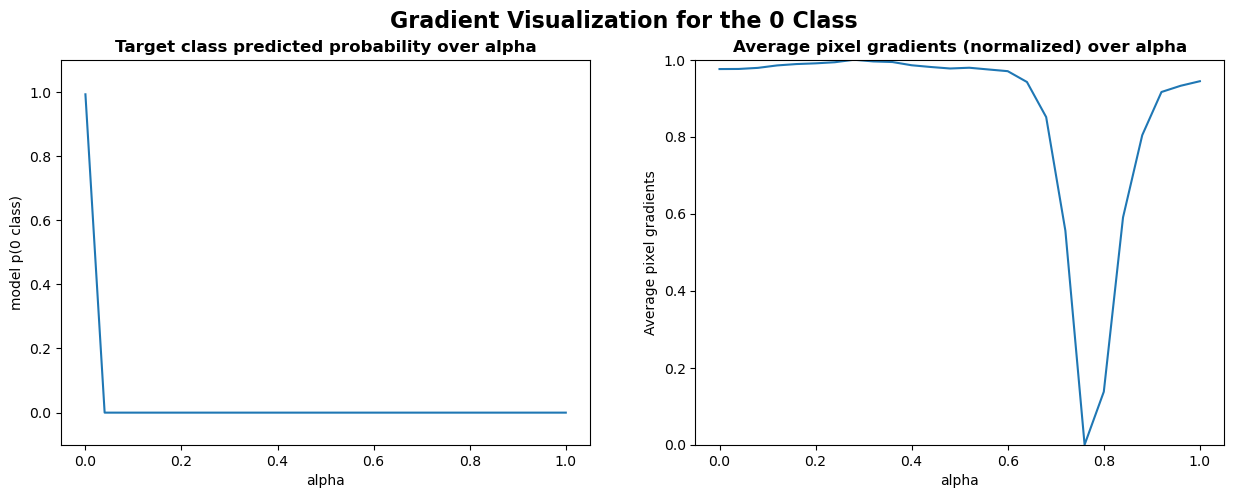

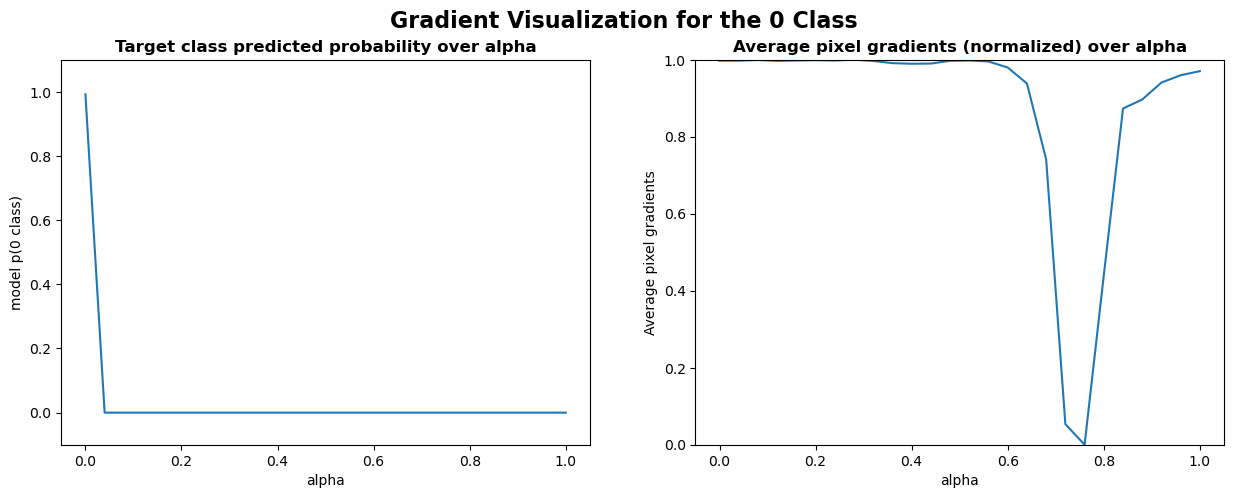

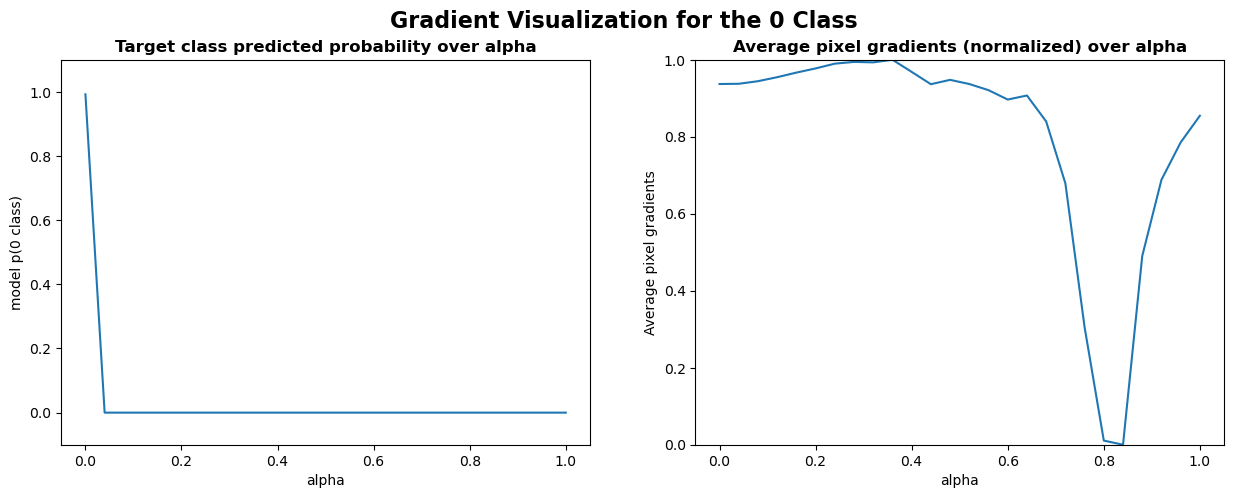

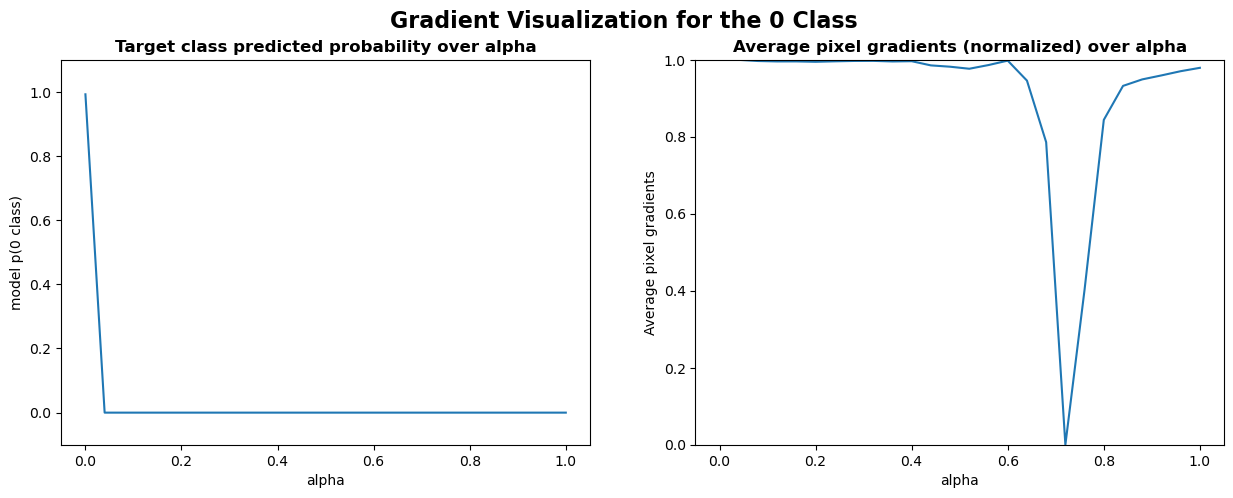

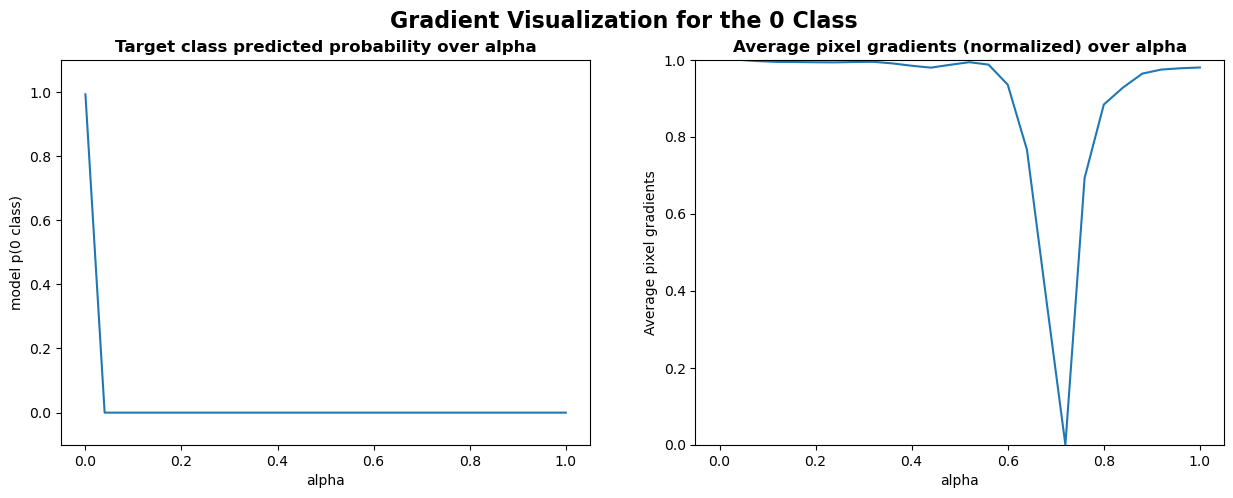

In [76]:
for i in range(5):
    viz_grad_saturation(ii_n[i]
                    , coga_n[i]
                    , 0)

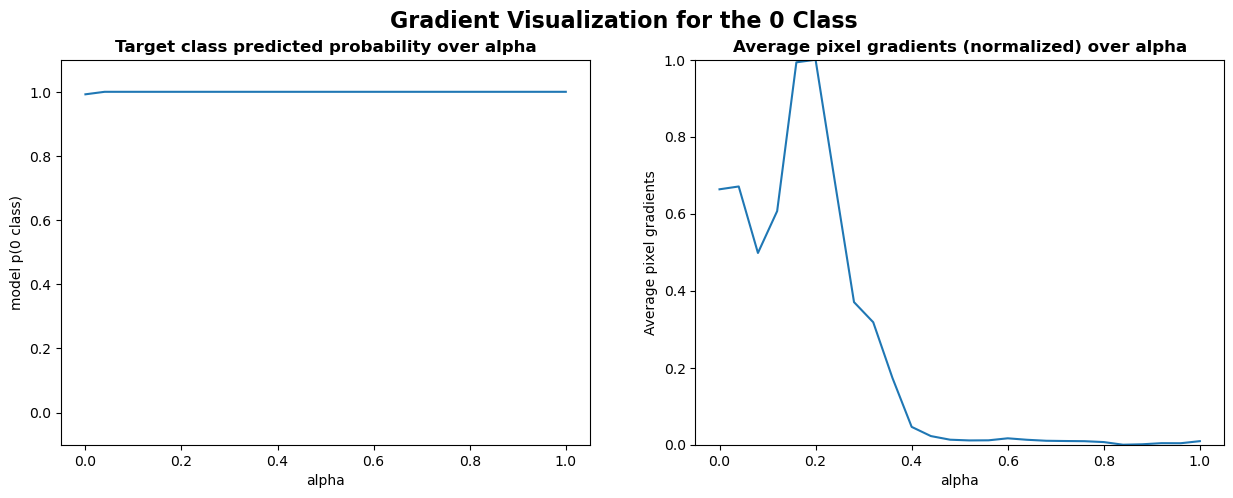

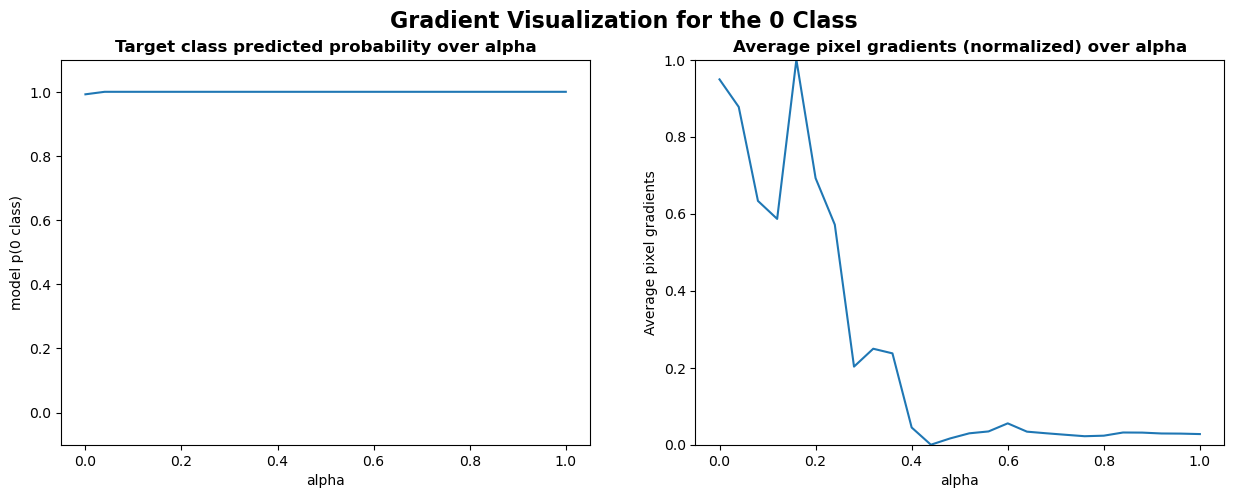

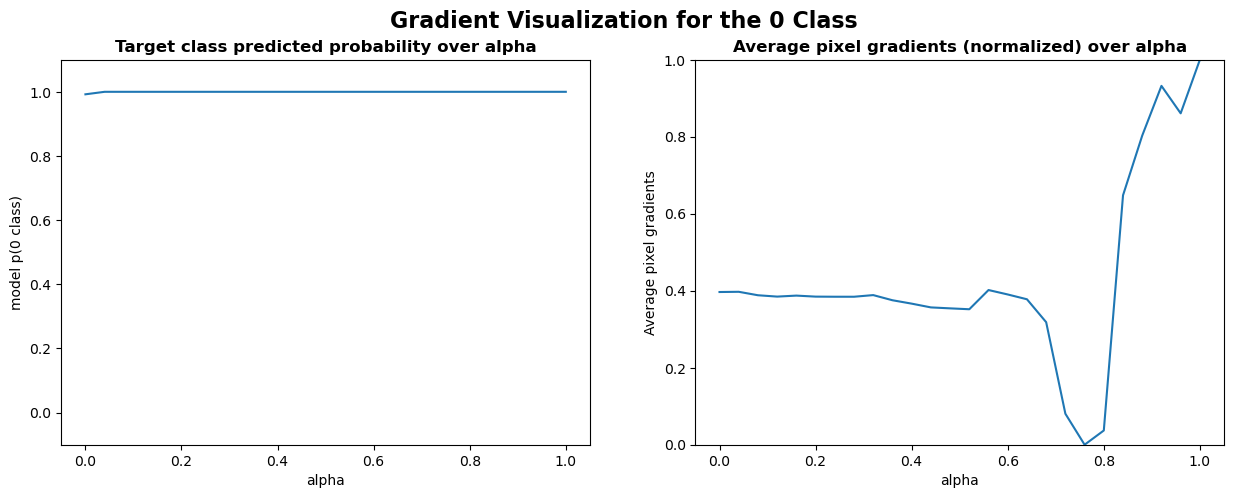

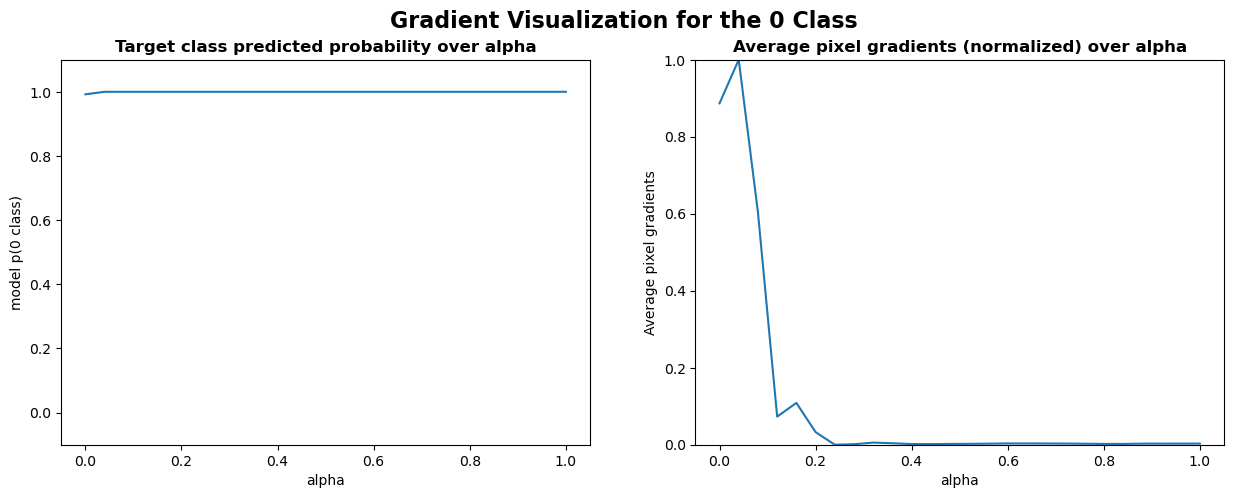

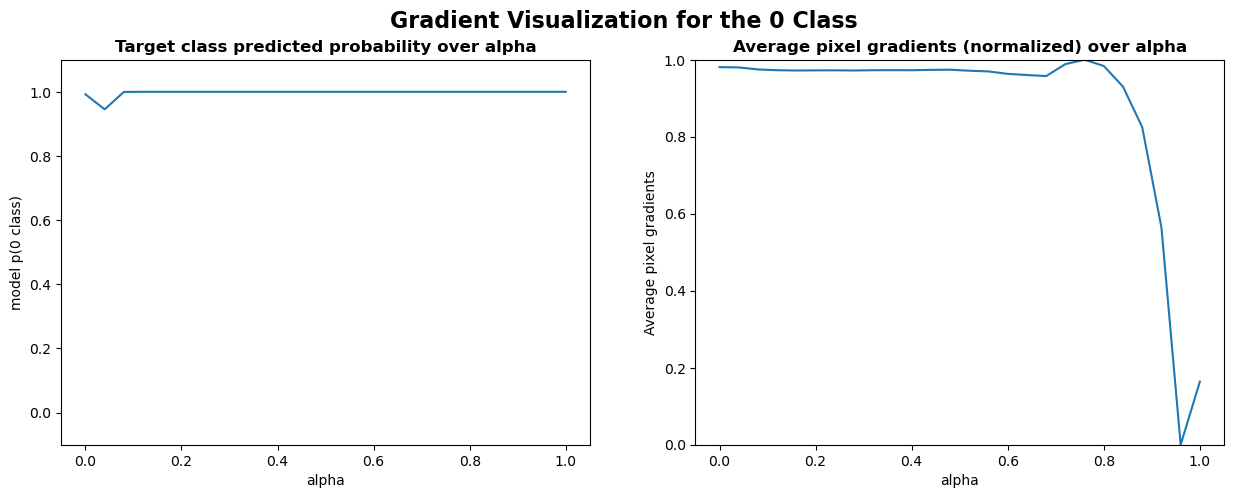

In [77]:
for i in range(5):
    viz_grad_saturation(ii_p[i]
                    , coga_p[i]
                    , 0)

In [78]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [80]:
ia_n = []
ia_p = []
for i in range(5):
    ia_n.append(integral_approximation(coga_n[i]))
    ia_p.append(integral_approximation(coga_p[i]))

In [126]:
pred = c3(ii_n[0])
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 0]

In [ ]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(a, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

In [ ]:
path_gradients = compute_gradients(images=interpolated_images,
                                   target_class_idx=555)


In [ ]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

In [ ]:
#@title
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

In [ ]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients


In [ ]:
ig_n= []
ig_p= []
for i in grad_n:
    integral_approximation(gradients = i)
for i in grad_p:
    integral_approximation(gradients = i)

In [ ]:
@tf.function(experimental_relax_shapes=False)
def integrated_gradients(baseline,
                         image,
                         target_class_idx = 0,
                         m_steps=50,
                         batch_size=32):
    
    if tf.math.reduce_max(image)<=1.:
        image *= 255.
    if tf.math.reduce_max(baseline)<=1.:
        baseline *= 255.
    
    # Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Collect gradients.    
    gradient_batches = []
    
    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)
      
    # Concatenate path gradients together row-wise into single tensor.
    total_gradients = tf.concat(gradient_batches, axis=0)

    # Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

In [ ]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [ ]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['Fireboat'],
                                       target_class_idx=555,
                                       m_steps=240)

In [ ]:
#@title
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

In [ ]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

K

In [ ]:
def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(valid_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))


outputs = model(images)

_, predicted = torch.max(outputs, 1)

In [ ]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [ ]:
# https://www.kaggle.com/code/ohseokkim/let-s-understanding-cnn-model/notebook
for ind in range(5):
    print('---'*20)
    print(f'indicaton = {ind}')
    input = images[ind].unsqueeze(0)
    input.requires_grad = True
    
    saliency = Saliency(model)
    grads = saliency.attribute(input, target=labels[ind].item())
    squeeze_grads = grads.squeeze().cpu().detach()
    squeeze_grads = torch.unsqueeze(squeeze_grads,0).numpy()
    grads = np.transpose(squeeze_grads, (1, 2, 0))
    
    ig = IntegratedGradients(model)
    attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
    squeeze_ig = attr_ig.squeeze().cpu().detach()
    squeeze_ig = torch.unsqueeze(squeeze_ig,0).numpy()
    attr_ig = np.transpose(squeeze_ig, (1, 2, 0))
    #print('Approximation delta: ', abs(delta))
    
    original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

    _ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

    _ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

    _ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

## Q4: Grad-CAM (5 Pts)

Grad-CAM is another post-hoc method that generates attribution maps. Like in Q3, implement the method and visualize attribution maps of five healthy and five disease test samples. Do the maps highlight sensible regions? Are attributions consistent across samples? Compare your findings with Q3.

https://www.kaggle.com/code/tavetisyan/x-ray-pneumonia-detection-97-test-accuracy

using the same 5 healthy and diseases samples as in Q3

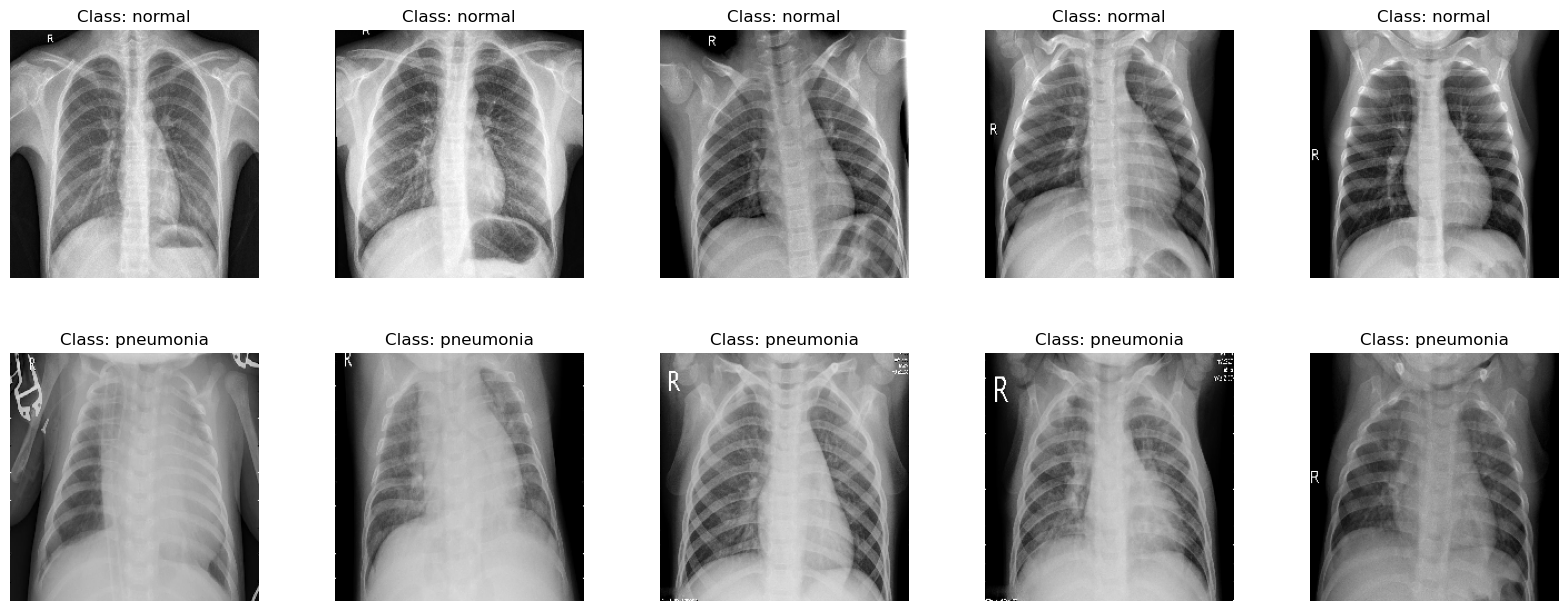

In [105]:
samples_s = test_generator_n.__next__()
imagess = samples_s[0]
targets = samples_s[1]
pnom = []
norm = []
plt.figure(figsize = (20 , 20))
for i in range(10):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(imagess[i])
    plt.title(f"Class: {labels[int(targets[i])]}")
    plt.axis('off')
    if targets[i] == 1:
        pnom.append(imagess[i])
    else:
        norm.append(imagess[i])

### Grad-Cam Algorithm

In [97]:
# Load model
grad_cam_model = load_model("model_1")

In [98]:
grad_cam_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [99]:
# Remove last layer's sigmoid
grad_cam_model.layers[-1].activation = None

last_conv_layer_name = "conv2d_3"

In [101]:
def grad_cam_heatmap(img_array, model, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [102]:
def get_img_array(img):
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

preprocess_input = keras.applications.xception.preprocess_input    

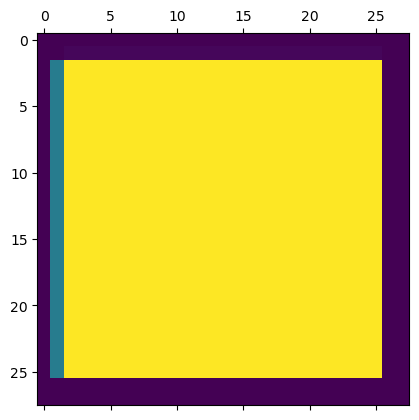

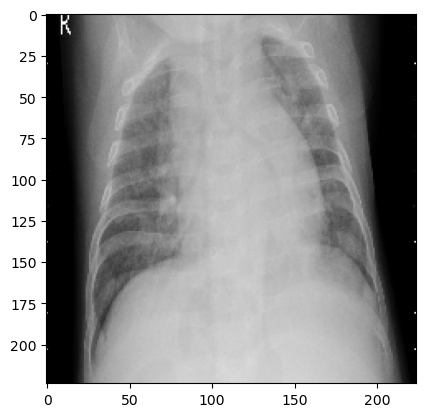

In [109]:
# Prepare image
img_array = preprocess_input(get_img_array(norm[1]))

# Generate class activation heatmap
heatmap = grad_cam_heatmap(img_array, grad_cam_model)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Display image
plt.imshow(pnom[1])
plt.show()

### Superimposed Visualization

/var/folders/x6/vpw6gfrj0dqg14k3cvcvlfqh0000gn/T/ipykernel_7427/593676390.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


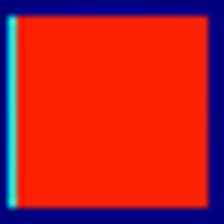

In [94]:
import matplotlib.cm as cm

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.1):

    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-224
    heatmap = np.uint8(224 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    display(superimposed_img)


save_and_display_gradcam(norm[1], heatmap)

# Appendix

In [ ]:
# copied https://www.kaggle.com/code/srishtik05/normal-vs-pneumonia-cnn
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

In [ ]:
# copied https://www.kaggle.com/code/srishtik05/normal-vs-pneumonia-cnn
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

When we have an imbalance data, using a normal loss function will result a model that bias toward the dominating class. One solution is to use a weighted loss function. Using weighted loss function will balance the contribution in the loss function.

L𝑤𝑐𝑟𝑜𝑠𝑠−𝑒𝑛𝑡𝑟𝑜𝑝𝑦(𝑥)=−(𝑤𝑝𝑦log(𝑓(𝑥))+𝑤𝑛(1−𝑦)log(1−𝑓(𝑥))).
-(w1ylog(f(x)))+ w2(1−𝑦)log(1−𝑓(𝑥)))

In [ ]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")
...
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

In [176]:
img_size = 224 # or 224
batch_size= 32 # default
color = 'rgb'

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range=30,
                                   brightness_range=[0.6,1.2],
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale = 1./255.,)

test_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = train_datagen.flow_from_directory('chest_xray/train',
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    color_mode=color, # default
                                                    shuffle = True,
                                                    class_mode ='binary',
                                                    seed = 99)

val_generator = val_datagen.flow_from_directory('chest_xray/val',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False,
                                                class_mode ='binary',
                                                seed = 99)

test_generator = test_datagen.flow_from_directory('chest_xray/test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False, 
                                                class_mode ='binary',
                                                seed = 99)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [169]:
img_size = 224 
batch_size= 32 # default
color = 'rgb' # colored images -> channels = 3

train_datagen1 = ImageDataGenerator(rescale = 1./255., # normalize
                                   rotation_range=30, #0  # randomly rotate images in the range (degrees, 0 to 180)
                                   brightness_range=[0.6,1.2],
                                   # zoom_range = 0.2, #0.0 # randomly zoom image 
                                   width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                                   horizontal_flip=True, # Randomly flip inputs horizontally
                                   validation_split=0.1 # Used to create the random split
                                  )


test_datagen1 = ImageDataGenerator(rescale=1/255.) # normalize


train_generator1 = train_datagen1.flow_from_directory('chest_xray/train_val', # note that we now use the folder that contains both train and validation data
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    color_mode=color, # default
                                                    shuffle = True,
                                                    class_mode ='binary',
                                                    subset = 'training',
                                                    seed = 99)

val_generator1 = train_datagen1.flow_from_directory('chest_xray/train_val', # note that we now use the folder that contains both train and validation data
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = True,
                                                class_mode ='binary',
                                                subset = 'validation', 
                                                seed = 99)


test_generator1 = test_datagen1.flow_from_directory('chest_xray/test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False, 
                                                class_mode ='binary',
                                                seed = 99)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [170]:
channel = 3
cnn1 = Sequential()

cnn1.add(Conv2D(16,3, input_shape=(img_size,img_size,channel), activation='relu', padding='same'))
cnn1.add(MaxPooling2D((2,2) , padding = 'same'))

cnn1.add(Conv2D(32,3, activation='relu', padding='same'))
cnn1.add(Dropout(0.1))
cnn1.add(MaxPooling2D((2,2) , padding = 'same'))

cnn1.add(Conv2D(64,3, activation='relu', padding='same'))
cnn1.add(MaxPooling2D((2,2) , padding = 'same'))
cnn1.add(Dropout(0.2))

cnn1.add(Conv2D(64,3, activation='relu', padding='same'))
cnn1.add(MaxPooling2D((2,2) , padding = 'same'))

cnn1.add(Flatten())

cnn1.add(Dense(256, activation ='relu'))
cnn1.add(Dense(1, activation = 'sigmoid'))

cnn1.compile(optimizer= 'nadam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

history1 = cnn1.fit(train_generator1, 
                  validation_data= val_generator1,
                  epochs = 10 # 200
                  #, callbacks= [checkpoint]
                 )

Epoch 1/10
148/148 [==============================] - 104s 696ms/step - loss: 0.4446 - accuracy: 0.7892 - recall_2: 0.9250 - val_loss: 0.2895 - val_accuracy: 0.8563 - val_recall_2: 0.9588
Epoch 2/10
148/148 [==============================] - 97s 653ms/step - loss: 0.2825 - accuracy: 0.8800 - recall_2: 0.9156 - val_loss: 0.2654 - val_accuracy: 0.8736 - val_recall_2: 0.8711
Epoch 3/10
148/148 [==============================] - 96s 649ms/step - loss: 0.2121 - accuracy: 0.9168 - recall_2: 0.9411 - val_loss: 0.3048 - val_accuracy: 0.8525 - val_recall_2: 0.9897
Epoch 4/10
148/148 [==============================] - 97s 653ms/step - loss: 0.1823 - accuracy: 0.9274 - recall_2: 0.9514 - val_loss: 0.1893 - val_accuracy: 0.9291 - val_recall_2: 0.9381
Epoch 5/10
148/148 [==============================] - 97s 651ms/step - loss: 0.1728 - accuracy: 0.9316 - recall_2: 0.9536 - val_loss: 0.2128 - val_accuracy: 0.9195 - val_recall_2: 0.9149
Epoch 6/10
148/148 [==============================] - 98s 662ms/

20/20 [==============================] - 4s 193ms/step
              precision    recall  f1-score   support

      Normal       0.92      0.53      0.68       234
   Pneumonia       0.78      0.97      0.86       390

    accuracy                           0.81       624
   macro avg       0.85      0.75      0.77       624
weighted avg       0.83      0.81      0.79       624

test accuracy of model is 80.76923076923077
test recall of model is 97.17948717948718
test precision of model is 77.6639344262295
test f1 Score of model is 86.33257403189066


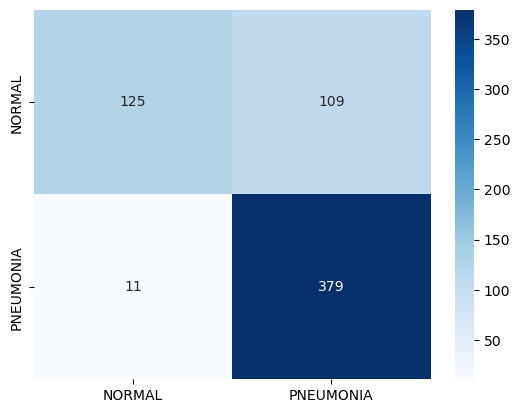

In [172]:
pred_eval(cnn1, 'test')

In [162]:
img_size = 224 
batch_size= 32 # default
color = 'rgb' # colored images -> channels = 3

train_datagen = ImageDataGenerator(rescale = 1./255., # normalize
                                   rotation_range=30, #0  # randomly rotate images in the range (degrees, 0 to 180)
                                   brightness_range=[0.6,1.2],
                                   # zoom_range = 0.2, #0.0 # randomly zoom image 
                                   width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                                   horizontal_flip=True # Randomly flip inputs horizontally
                                  )


val_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = train_datagen.flow_from_directory('chest_xray/train',
                                                    target_size= (img_size, img_size),
                                                    batch_size = batch_size,
                                                    color_mode=color, # default
                                                    shuffle = True,
                                                    class_mode ='binary',
                                                    seed = 99)

val_generator = val_datagen.flow_from_directory('chest_xray/val',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False,
                                                class_mode ='binary',
                                                seed = 99)

test_generator = test_datagen.flow_from_directory('chest_xray/test',
                                                target_size= (img_size, img_size),
                                                batch_size = batch_size,
                                                color_mode=color, # default
                                                shuffle = False, 
                                                class_mode ='binary',
                                                seed = 99)
labels = ['Normal','Pneumonia']
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')
plt.show()

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [173]:
channel = 3
cnn2 = Sequential()

cnn2.add(Conv2D(16,3, input_shape=(img_size,img_size,channel), activation='relu', padding='same'))
cnn2.add(MaxPooling2D((2,2) , padding = 'same'))

cnn2.add(Conv2D(32,3, activation='relu', padding='same'))
cnn2.add(Dropout(0.1))
cnn2.add(MaxPooling2D((2,2) , padding = 'same'))

cnn2.add(Conv2D(64,3, activation='relu', padding='same'))
cnn2.add(MaxPooling2D((2,2) , padding = 'same'))
cnn2.add(Dropout(0.2))

cnn2.add(Conv2D(64,3, activation='relu', padding='same'))
cnn2.add(MaxPooling2D((2,2) , padding = 'same'))

cnn2.add(Flatten())

cnn2.add(Dense(256, activation ='relu'))
cnn2.add(Dense(1, activation = 'sigmoid'))

cnn2.compile(optimizer= 'nadam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

history = cnn2.fit(train_generator, 
                  validation_data= val_generator,
                  epochs = 10 # 200
                  #, callbacks= [checkpoint]
                 )

Epoch 1/10
163/163 [==============================] - 105s 636ms/step - loss: 0.4263 - accuracy: 0.7866 - recall_3: 0.8981 - val_loss: 0.9453 - val_accuracy: 0.6250 - val_recall_3: 1.0000
Epoch 2/10
163/163 [==============================] - 99s 604ms/step - loss: 0.2790 - accuracy: 0.8744 - recall_3: 0.9099 - val_loss: 1.2748 - val_accuracy: 0.6250 - val_recall_3: 1.0000
Epoch 3/10
163/163 [==============================] - 97s 591ms/step - loss: 0.2283 - accuracy: 0.9024 - recall_3: 0.9298 - val_loss: 0.9754 - val_accuracy: 0.6875 - val_recall_3: 1.0000
Epoch 4/10
163/163 [==============================] - 96s 588ms/step - loss: 0.1888 - accuracy: 0.9235 - recall_3: 0.9481 - val_loss: 0.8650 - val_accuracy: 0.6875 - val_recall_3: 1.0000
Epoch 5/10
163/163 [==============================] - 99s 603ms/step - loss: 0.1659 - accuracy: 0.9358 - recall_3: 0.9551 - val_loss: 0.3806 - val_accuracy: 0.7500 - val_recall_3: 0.7500
Epoch 6/10
163/163 [==============================] - 97s 593ms/

20/20 [==============================] - 1034s 54s/step
              precision    recall  f1-score   support

      Normal       0.86      0.65      0.74       234
   Pneumonia       0.81      0.94      0.87       390

    accuracy                           0.83       624
   macro avg       0.84      0.79      0.80       624
weighted avg       0.83      0.83      0.82       624

test accuracy of model is 82.6923076923077
test recall of model is 93.58974358974359
test precision of model is 81.47321428571429
test f1 Score of model is 87.11217183770883


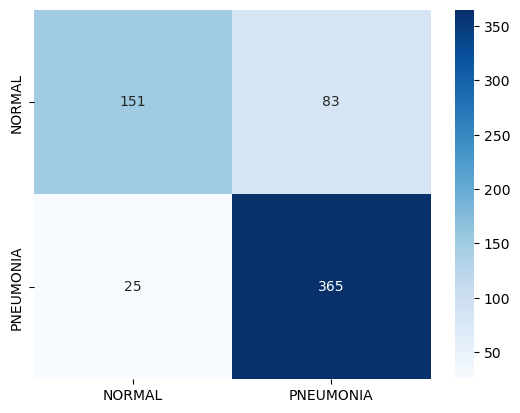

In [174]:
pred_eval(cnn2, 'test')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


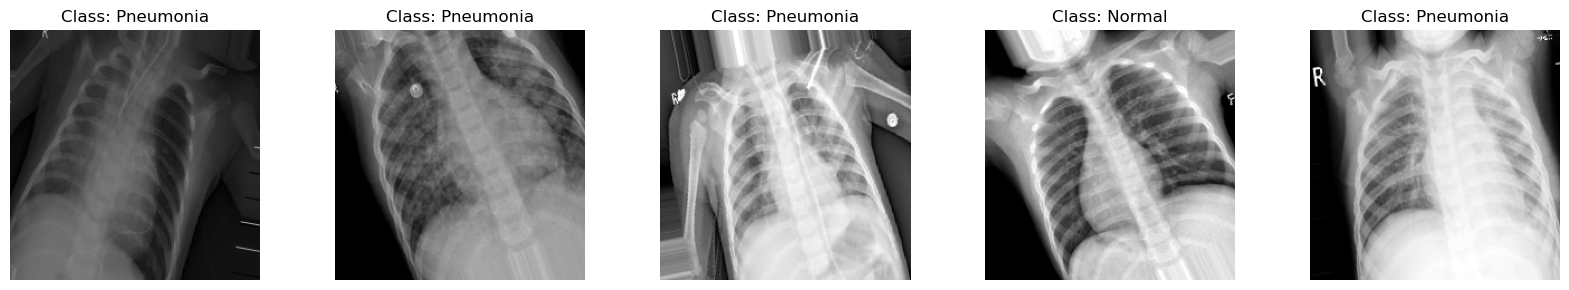

Epoch 1/10
163/163 [==============================] - 98s 592ms/step - loss: 0.4839 - accuracy: 0.7776 - recall_1: 0.9515 - val_loss: 0.8792 - val_accuracy: 0.6875 - val_recall_1: 1.0000
Epoch 2/10
163/163 [==============================] - 95s 583ms/step - loss: 0.2720 - accuracy: 0.8882 - recall_1: 0.9301 - val_loss: 0.6489 - val_accuracy: 0.8125 - val_recall_1: 1.0000
Epoch 3/10
163/163 [==============================] - 95s 582ms/step - loss: 0.2045 - accuracy: 0.9185 - recall_1: 0.9455 - val_loss: 1.1077 - val_accuracy: 0.6250 - val_recall_1: 1.0000
Epoch 4/10
163/163 [==============================] - 97s 593ms/step - loss: 0.1780 - accuracy: 0.9316 - recall_1: 0.9554 - val_loss: 1.3973 - val_accuracy: 0.6875 - val_recall_1: 1.0000
Epoch 5/10
163/163 [==============================] - 96s 589ms/step - loss: 0.1554 - accuracy: 0.9436 - recall_1: 0.9615 - val_loss: 1.2703 - val_accuracy: 0.6875 - val_recall_1: 1.0000
Epoch 6/10
163/163 [==============================] - 92s 561ms/s

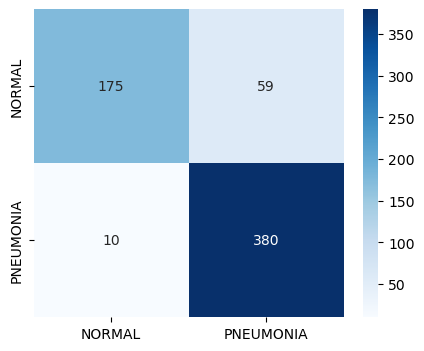

Accuracy of model is 88.9423076923077
Recall of model is 97.43589743589743
Precision of model is 86.56036446469248
F1 Score of model is 91.67671893848008


In [166]:
channel = 3
cnn = Sequential()

cnn.add(Conv2D(16,3, input_shape=(img_size,img_size,channel), activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(32,3, activation='relu', padding='same'))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(64,3, activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2) , padding = 'same'))

cnn.add(Flatten())

cnn.add(Dense(256, activation ='relu'))
cnn.add(Dense(1, activation = 'sigmoid'))

cnn.compile(optimizer= 'nadam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tf.keras.metrics.Recall()])

history = cnn.fit(train_generator2, 
                  validation_data= val_generator,
                  epochs = 10 # 200
                  #, callbacks= [checkpoint]
                 )

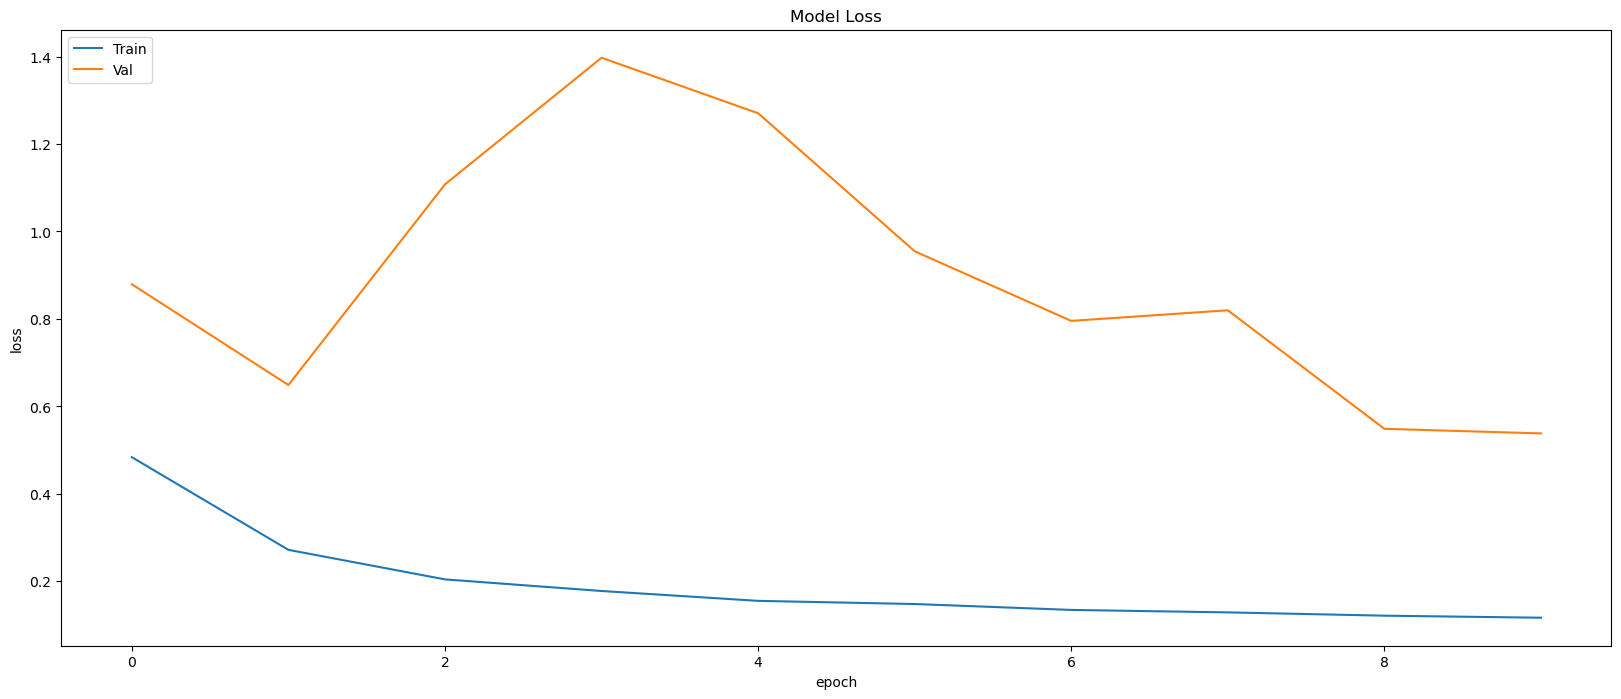

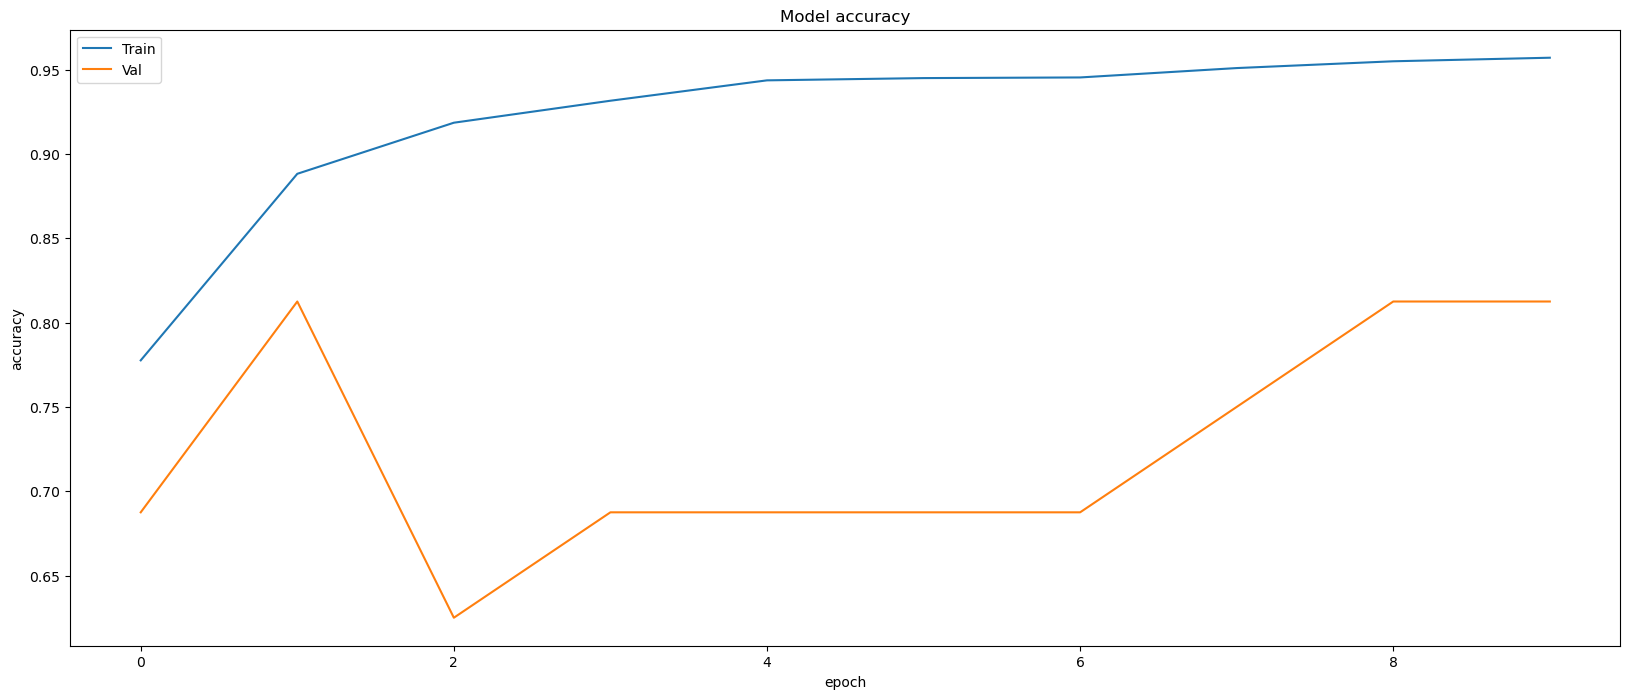

In [168]:
loss_acc_plot(history)

20/20 [==============================] - 4s 187ms/step
              precision    recall  f1-score   support

      Normal       0.95      0.75      0.84       234
   Pneumonia       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624

test accuracy of model is 88.9423076923077
test recall of model is 97.43589743589743
test precision of model is 86.56036446469248
test f1 Score of model is 91.67671893848008


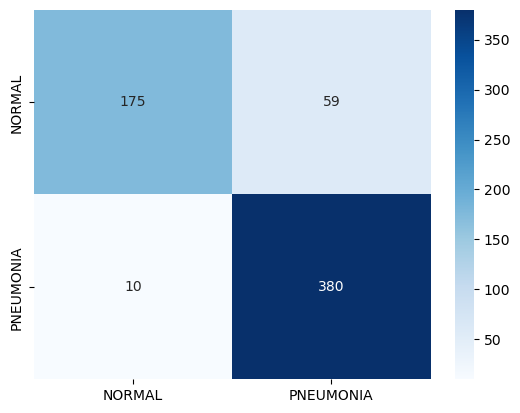

In [167]:
pred_eval(cnn, 'test')